## Kerasによる銀河形態分類（Hubble系列8クラス）畳み込みニューラルネット  
### Chollet, F. (2018). *Deep Learning with Python.* Manning Publications Co. Chapter 5参照


In [1]:
import os, shutil
import sys, time
import keras
print(keras.__version__)

# 作業用ディレクトリ定義（要カスタマイズ）
galaxy_data_directory = '/home/satoshi/Galaxy/'

Using TensorFlow backend.


2.2.0


#### Keras Conv2Dモデル  input_shape;150

In [2]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

#### モデルのコンパイル

In [3]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
        optimizer=optimizers.RMSprop(lr=1e-4),
        metrics=['acc'])

#### イメージデータジェネレータ(Data augmentationあり)
#### ランダムデータセット　dataset_8class_random_256_01_4000

In [4]:
from keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator用訓練データディレクトリ
train_generator_directory = galaxy_data_directory + 'train'
# ImageDataGenerator用検証データディレクトリ
validation_generator_directory = galaxy_data_directory + 'validation'
# ImageDataGenerator用テストデータディレクトリ
test_generator_directory = galaxy_data_directory + 'test'

# 訓練データのaugmentation　
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40, 
    width_shift_range=0.2,
    height_shift_range=0.2, 
    #shear_range=0.2, 
    zoom_range=0.2, )
    #horizontal_flip=True, )
    
# 訓練データジェネレータ　バッチサイズ：　40
train_generator = train_datagen.flow_from_directory(
        train_generator_directory,
        target_size=(150, 150),
        batch_size=40,
        class_mode='categorical')
print(train_generator.class_indices)

# 検証データジェネレータ　バッチサイズ：　40
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
        validation_generator_directory,
        target_size=(150, 150),
        batch_size=40,
        class_mode='categorical')
print(validation_generator.class_indices)

# テストデータジェネレータ　バッチサイズ：　40
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_generator_directory,
        target_size=(150, 150),
        batch_size=40,
        class_mode='categorical')
print(test_generator.class_indices)

Found 16000 images belonging to 8 classes.
{'E0': 0, 'E3': 1, 'E7': 2, 'Edgeon': 3, 'S0': 4, 'SB0': 5, 'SBabc': 6, 'Sabc': 7}
Found 8000 images belonging to 8 classes.
{'E0': 0, 'E3': 1, 'E7': 2, 'Edgeon': 3, 'S0': 4, 'SB0': 5, 'SBabc': 6, 'Sabc': 7}
Found 8000 images belonging to 8 classes.
{'E0': 0, 'E3': 1, 'E7': 2, 'Edgeon': 3, 'S0': 4, 'SB0': 5, 'SBabc': 6, 'Sabc': 7}


#### モデルの学習

In [5]:
# 学習　エポック数：　200
history = model.fit_generator(
        train_generator,
        # 訓練データ件数8x2000=16000, バッチサイズ40 => 16000/40=400 steps/epoch
        steps_per_epoch=400,  
        epochs=200,
        # 検証データ件数8x1000=8000, バッチサイズ40 => 8000/40=200 steps/epoch
        validation_data=validation_generator,
        validation_steps=200)

Epoch 1/200
400/400 [==============================] - 87s 218ms/step - loss: 1.6577 - acc: 0.2887 - val_loss: 1.4667 - val_acc: 0.3768
Epoch 2/200
400/400 [==============================] - 83s 208ms/step - loss: 1.4910 - acc: 0.3846 - val_loss: 1.3096 - val_acc: 0.4622
Epoch 3/200
400/400 [==============================] - 83s 208ms/step - loss: 1.3808 - acc: 0.4240 - val_loss: 1.2106 - val_acc: 0.4889
Epoch 4/200
400/400 [==============================] - 84s 210ms/step - loss: 1.3181 - acc: 0.4499 - val_loss: 1.1969 - val_acc: 0.4895
Epoch 5/200
400/400 [==============================] - 85s 211ms/step - loss: 1.2813 - acc: 0.4694 - val_loss: 1.1864 - val_acc: 0.4970
Epoch 6/200
400/400 [==============================] - 83s 207ms/step - loss: 1.2583 - acc: 0.4775 - val_loss: 1.1121 - val_acc: 0.5327
Epoch 7/200
400/400 [==============================] - 84s 210ms/step - loss: 1.2218 - acc: 0.4931 - val_loss: 1.1311 - val_acc: 0.5267
Epoch 8/200
400/400 [===========================

Epoch 61/200
400/400 [==============================] - 84s 211ms/step - loss: 0.8899 - acc: 0.6350 - val_loss: 0.8610 - val_acc: 0.6477
Epoch 62/200
400/400 [==============================] - 84s 209ms/step - loss: 0.8941 - acc: 0.6381 - val_loss: 0.8430 - val_acc: 0.6666
Epoch 63/200
400/400 [==============================] - 85s 211ms/step - loss: 0.8966 - acc: 0.6345 - val_loss: 0.8456 - val_acc: 0.6603
Epoch 64/200
400/400 [==============================] - 84s 210ms/step - loss: 0.8854 - acc: 0.6396 - val_loss: 0.8307 - val_acc: 0.6690
Epoch 65/200
400/400 [==============================] - 84s 210ms/step - loss: 0.8928 - acc: 0.6406 - val_loss: 0.8271 - val_acc: 0.6645
Epoch 66/200
400/400 [==============================] - 84s 211ms/step - loss: 0.8817 - acc: 0.6381 - val_loss: 0.8324 - val_acc: 0.6691
Epoch 67/200
400/400 [==============================] - 84s 210ms/step - loss: 0.8862 - acc: 0.6409 - val_loss: 0.8458 - val_acc: 0.6671
Epoch 68/200
400/400 [===================

400/400 [==============================] - 85s 214ms/step - loss: 0.8517 - acc: 0.6601 - val_loss: 0.7984 - val_acc: 0.6831
Epoch 180/200
400/400 [==============================] - 84s 210ms/step - loss: 0.8490 - acc: 0.6539 - val_loss: 0.8061 - val_acc: 0.6880
Epoch 181/200
400/400 [==============================] - 84s 210ms/step - loss: 0.8575 - acc: 0.6571 - val_loss: 0.8236 - val_acc: 0.6680
Epoch 182/200
400/400 [==============================] - 84s 211ms/step - loss: 0.8545 - acc: 0.6611 - val_loss: 0.8251 - val_acc: 0.6692
Epoch 183/200
400/400 [==============================] - 84s 209ms/step - loss: 0.8529 - acc: 0.6605 - val_loss: 0.8636 - val_acc: 0.6490
Epoch 184/200
400/400 [==============================] - 84s 210ms/step - loss: 0.8384 - acc: 0.6636 - val_loss: 0.8300 - val_acc: 0.6769
Epoch 185/200
400/400 [==============================] - 83s 208ms/step - loss: 0.8553 - acc: 0.6646 - val_loss: 0.8493 - val_acc: 0.6726
Epoch 186/200
400/400 [=========================

In [6]:
# モデルの退避
model.save(galaxy_data_directory + 'galaxy_cnn_8class_256px_sf01_random_model.h5')

#### 学習履歴のビジュアル化

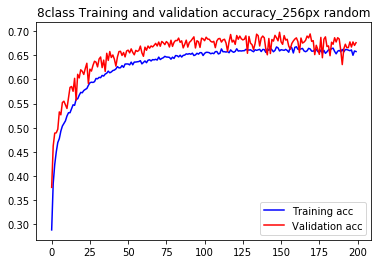

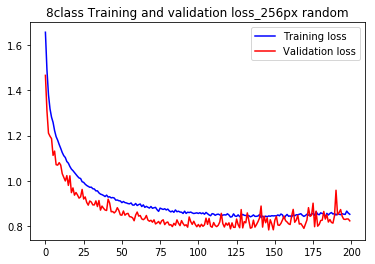

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('8class Training and validation accuracy_256px random')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('8class Training and validation loss_256px random')
plt.legend()

plt.show()

#### テストデータセットによる精度評価

In [8]:
metric = model.evaluate_generator(test_generator)
print('Test loss = ', metric[0])
print('Test acc  = ', metric[1])

Test loss =  0.8024683789908886
Test acc  =  0.6897500026226043


#### テストデータセットからサンプリングした銀河イメージデータについての形態クラス予測結果

{'E0': 0, 'E3': 1, 'E7': 2, 'Edgeon': 3, 'S0': 4, 'SB0': 5, 'SBabc': 6, 'Sabc': 7}
E0_0_7_111_587733081351127102.jpeg
E3 : 51%   E0 : 48%   E7 : 0%   Sabc : 0%   S0 : 0%   SBabc : 0%   SB0 : 0%   Edgeon : 0%   


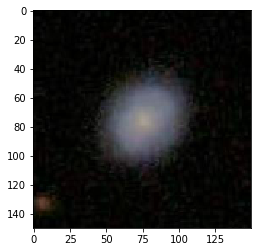

E0_4_15_30_588023720709980230.jpeg
E0 : 93%   E3 : 6%   E7 : 0%   S0 : 0%   Sabc : 0%   SBabc : 0%   SB0 : 0%   Edgeon : 0%   


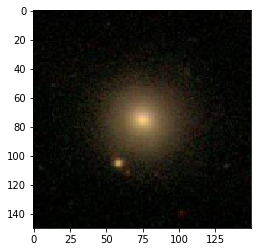

E0_10_6_43_587729160051228889.jpeg
E0 : 80%   E3 : 18%   E7 : 0%   S0 : 0%   Sabc : 0%   SBabc : 0%   SB0 : 0%   Edgeon : 0%   


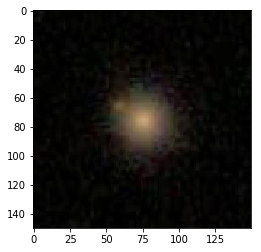

E0_4_3_73_587742014345576646.jpeg
E0 : 80%   E3 : 19%   E7 : 0%   S0 : 0%   Sabc : 0%   SB0 : 0%   SBabc : 0%   Edgeon : 0%   


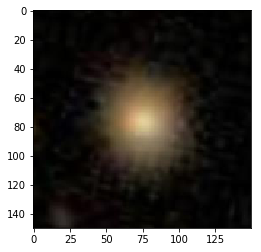

E0_11_7_21_588010136267718865.jpeg
E0 : 86%   E3 : 13%   E7 : 0%   S0 : 0%   Sabc : 0%   SB0 : 0%   SBabc : 0%   Edgeon : 0%   


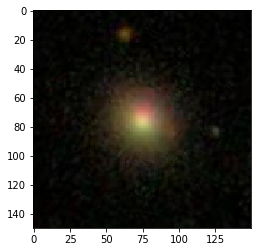

E0_13_5_31_587741603097608299.jpeg
E0 : 79%   E3 : 19%   E7 : 0%   S0 : 0%   Sabc : 0%   SB0 : 0%   SBabc : 0%   Edgeon : 0%   


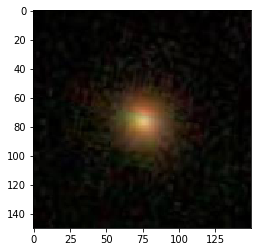

E0_10_5_41_588010360145313953.jpeg
E0 : 90%   E3 : 9%   E7 : 0%   S0 : 0%   Sabc : 0%   SB0 : 0%   SBabc : 0%   Edgeon : 0%   


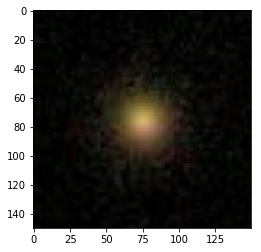

E0_7_7_48_587742954934829201.jpeg
E0 : 70%   E3 : 28%   E7 : 0%   S0 : 0%   Sabc : 0%   SBabc : 0%   SB0 : 0%   Edgeon : 0%   


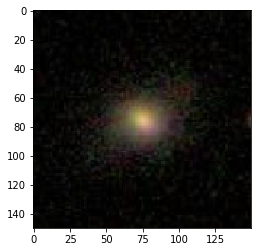

E0_11_13_25_587742610803654991.jpeg
E0 : 74%   E3 : 22%   E7 : 3%   S0 : 0%   Sabc : 0%   SBabc : 0%   SB0 : 0%   Edgeon : 0%   


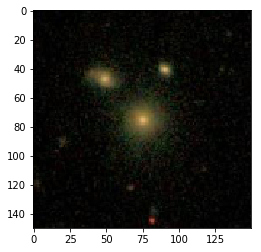

E0_9_5_35_587742062160576706.jpeg
E0 : 58%   E3 : 41%   E7 : 0%   S0 : 0%   SB0 : 0%   Sabc : 0%   SBabc : 0%   Edgeon : 0%   


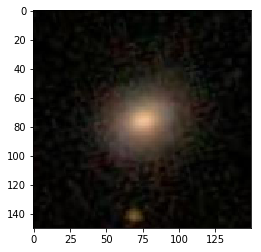

E3_6_4_61_588010359625023628.jpeg
E3 : 90%   E7 : 8%   E0 : 0%   S0 : 0%   SBabc : 0%   Sabc : 0%   SB0 : 0%   Edgeon : 0%   


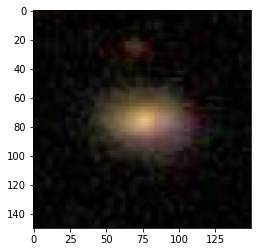

E3_5_6_39_587733432994627740.jpeg
E3 : 99%   E0 : 0%   E7 : 0%   S0 : 0%   SB0 : 0%   Sabc : 0%   SBabc : 0%   Edgeon : 0%   


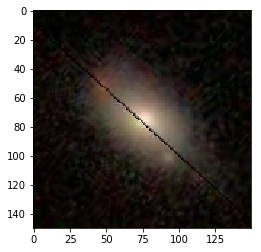

E3_4_4_78_588007005236101236.jpeg
E3 : 89%   E7 : 5%   E0 : 5%   S0 : 0%   SBabc : 0%   Sabc : 0%   SB0 : 0%   Edgeon : 0%   


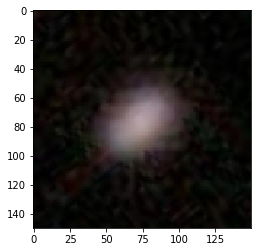

E3_2_7_83_587739844859462141.jpeg
E3 : 87%   E7 : 12%   SBabc : 0%   E0 : 0%   Sabc : 0%   S0 : 0%   Edgeon : 0%   SB0 : 0%   


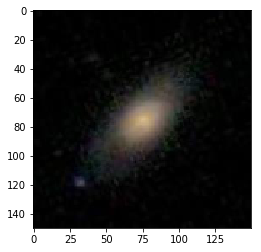

E3_10_5_44_587736618246996271.jpeg
E0 : 64%   E3 : 31%   E7 : 3%   S0 : 0%   Sabc : 0%   SB0 : 0%   SBabc : 0%   Edgeon : 0%   


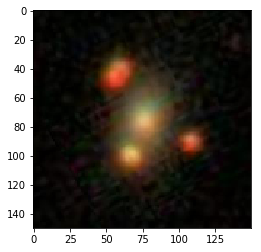

E3_9_4_43_588010358543614156.jpeg
E3 : 99%   E7 : 0%   E0 : 0%   S0 : 0%   SBabc : 0%   SB0 : 0%   Sabc : 0%   Edgeon : 0%   


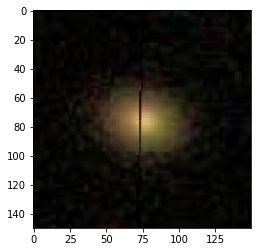

E3_4_5_51_587736808843903133.jpeg
E3 : 99%   E0 : 0%   E7 : 0%   S0 : 0%   SBabc : 0%   Sabc : 0%   SB0 : 0%   Edgeon : 0%   


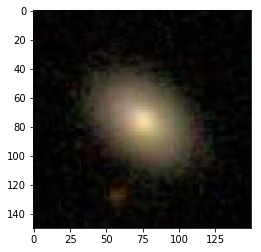

E3_12_7_37_587741821062742249.jpeg
E0 : 60%   E3 : 38%   E7 : 1%   S0 : 0%   Sabc : 0%   SBabc : 0%   SB0 : 0%   Edgeon : 0%   


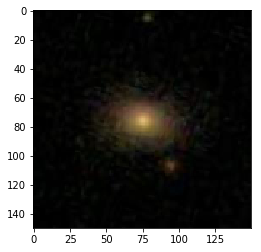

E3_8_5_54_588017703469318258.jpeg
E3 : 54%   E0 : 41%   E7 : 3%   S0 : 0%   Sabc : 0%   SB0 : 0%   SBabc : 0%   Edgeon : 0%   


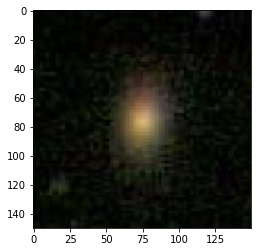

E3_6_4_57_588013382189449414.jpeg
E3 : 78%   E0 : 19%   E7 : 1%   S0 : 0%   SBabc : 0%   Sabc : 0%   SB0 : 0%   Edgeon : 0%   


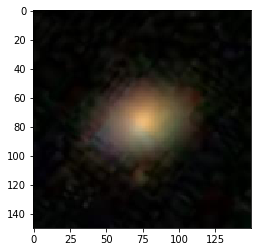

E7_13_13_14_587739407323103460.jpeg
E7 : 71%   E3 : 28%   E0 : 0%   S0 : 0%   SBabc : 0%   Edgeon : 0%   SB0 : 0%   Sabc : 0%   


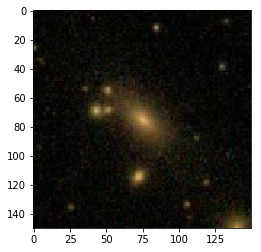

E7_1_12_90_587739719217971300.jpeg
E7 : 99%   Edgeon : 0%   E3 : 0%   SBabc : 0%   S0 : 0%   SB0 : 0%   Sabc : 0%   E0 : 0%   


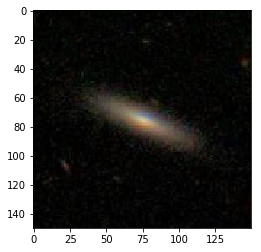

E7_7_4_52_588018056719106180.jpeg
E7 : 96%   E3 : 3%   Edgeon : 0%   S0 : 0%   SBabc : 0%   E0 : 0%   SB0 : 0%   Sabc : 0%   


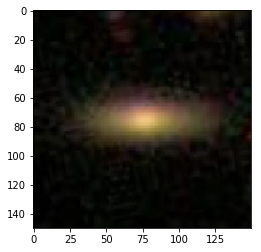

E7_8_4_52_587728947973587119.jpeg
E7 : 92%   E3 : 7%   Edgeon : 0%   E0 : 0%   SBabc : 0%   S0 : 0%   SB0 : 0%   Sabc : 0%   


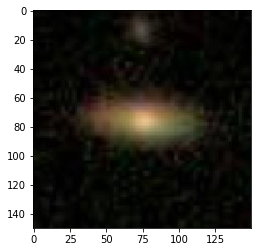

E7_12_8_25_587731680118112347.jpeg
E7 : 54%   E3 : 44%   E0 : 0%   S0 : 0%   Edgeon : 0%   SBabc : 0%   Sabc : 0%   SB0 : 0%   


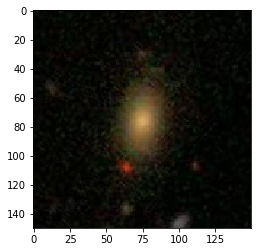

E7_10_4_41_588298662512623817.jpeg
E7 : 66%   E3 : 33%   SB0 : 0%   S0 : 0%   Edgeon : 0%   E0 : 0%   SBabc : 0%   Sabc : 0%   


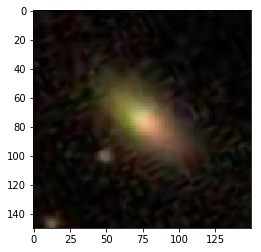

E7_3_8_73_588848898835021979.jpeg
E7 : 99%   E3 : 0%   Edgeon : 0%   SBabc : 0%   S0 : 0%   Sabc : 0%   SB0 : 0%   E0 : 0%   


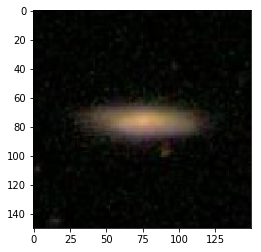

E7_1_8_91_587732590645412015.jpeg
E7 : 75%   E3 : 24%   Edgeon : 0%   S0 : 0%   SBabc : 0%   SB0 : 0%   Sabc : 0%   E0 : 0%   


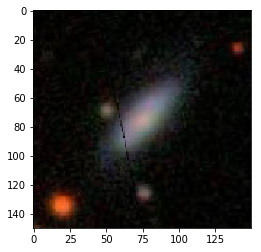

E7_1_10_89_587729158978339152.jpeg
E7 : 78%   Edgeon : 8%   E3 : 5%   SBabc : 4%   Sabc : 1%   S0 : 1%   SB0 : 0%   E0 : 0%   


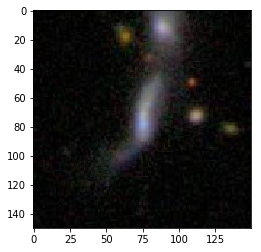

E7_2_7_69_587728906098311540.jpeg
E7 : 93%   E3 : 6%   Edgeon : 0%   E0 : 0%   SBabc : 0%   S0 : 0%   SB0 : 0%   Sabc : 0%   


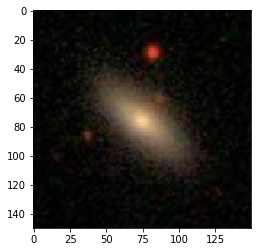

Edgeon_8_6_40_587726101490106540.jpeg
S0 : 28%   SB0 : 23%   Edgeon : 22%   Sabc : 13%   SBabc : 10%   E3 : 0%   E0 : 0%   E7 : 0%   


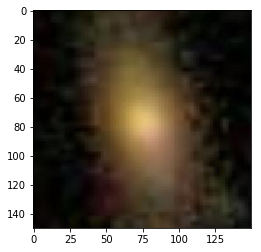

Edgeon_5_5_58_587729408617611598.jpeg
SB0 : 41%   Edgeon : 27%   S0 : 16%   SBabc : 10%   Sabc : 4%   E3 : 0%   E7 : 0%   E0 : 0%   


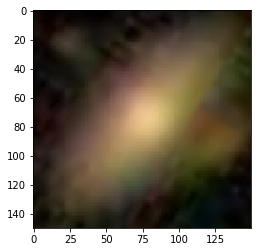

Edgeon_5_5_57_587742980174119083.jpeg
Edgeon : 83%   S0 : 9%   Sabc : 3%   SB0 : 1%   SBabc : 0%   E3 : 0%   E7 : 0%   E0 : 0%   


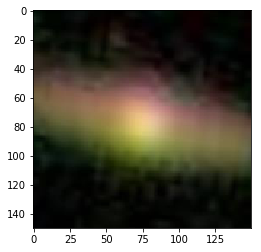

Edgeon_11_7_27_588007004159475887.jpeg
Edgeon : 81%   SB0 : 9%   S0 : 4%   Sabc : 2%   SBabc : 2%   E7 : 0%   E3 : 0%   E0 : 0%   


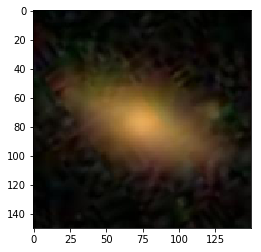

Edgeon_2_17_54_587735489208582349.jpeg
Edgeon : 99%   E7 : 0%   SBabc : 0%   E3 : 0%   S0 : 0%   Sabc : 0%   SB0 : 0%   E0 : 0%   


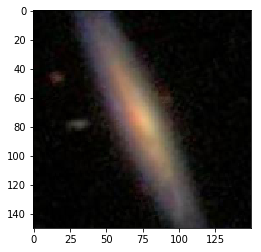

Edgeon_2_11_67_587732483821797594.jpeg
Edgeon : 99%   E7 : 0%   S0 : 0%   Sabc : 0%   E3 : 0%   SB0 : 0%   SBabc : 0%   E0 : 0%   


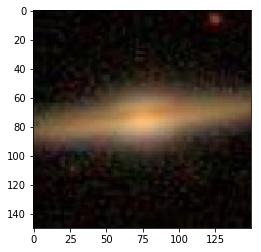

Edgeon_2_17_55_587738946145747047.jpeg
Edgeon : 93%   S0 : 2%   SB0 : 1%   Sabc : 1%   SBabc : 0%   E7 : 0%   E3 : 0%   E0 : 0%   


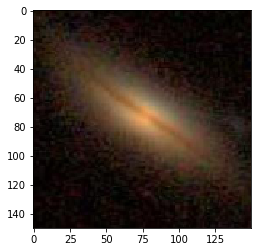

Edgeon_3_14_68_587736618789044640.jpeg
Edgeon : 99%   E7 : 0%   SBabc : 0%   E3 : 0%   S0 : 0%   Sabc : 0%   SB0 : 0%   E0 : 0%   


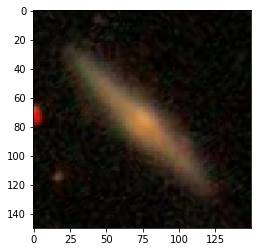

Edgeon_1_16_77_587739505009754235.jpeg
Edgeon : 99%   E7 : 0%   S0 : 0%   SBabc : 0%   Sabc : 0%   SB0 : 0%   E3 : 0%   E0 : 0%   


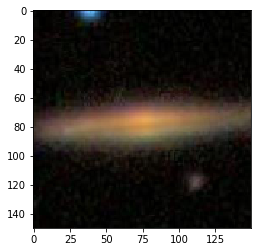

Edgeon_4_4_57_587736618247651343.jpeg
SB0 : 39%   Edgeon : 33%   S0 : 18%   Sabc : 4%   SBabc : 3%   E3 : 0%   E7 : 0%   E0 : 0%   


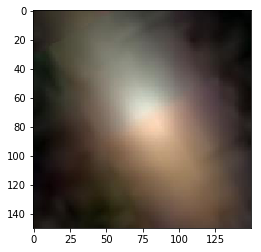

S0_8_5_51_588297865266462834.jpeg
S0 : 40%   SB0 : 26%   Sabc : 16%   SBabc : 15%   Edgeon : 0%   E0 : 0%   E3 : 0%   E7 : 0%   


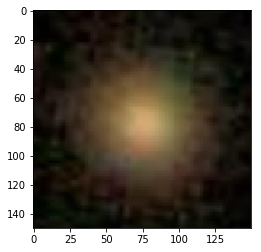

S0_8_11_34_587738948286742645.jpeg
S0 : 56%   SB0 : 19%   E0 : 12%   Sabc : 7%   SBabc : 2%   E3 : 1%   E7 : 0%   Edgeon : 0%   


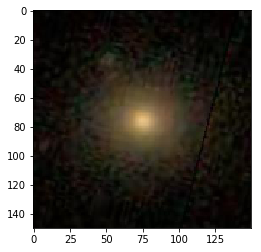

S0_12_5_32_587739609692307574.jpeg
S0 : 47%   SB0 : 22%   Sabc : 17%   SBabc : 11%   Edgeon : 0%   E0 : 0%   E3 : 0%   E7 : 0%   


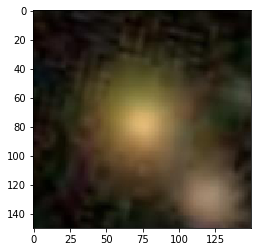

S0_8_6_43_587742610803130534.jpeg
S0 : 43%   SB0 : 31%   Sabc : 15%   SBabc : 6%   E0 : 1%   E3 : 0%   Edgeon : 0%   E7 : 0%   


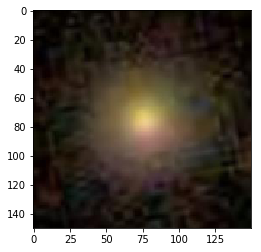

S0_11_6_32_587725074453299571.jpeg
SBabc : 41%   Sabc : 33%   SB0 : 14%   S0 : 10%   Edgeon : 0%   E3 : 0%   E0 : 0%   E7 : 0%   


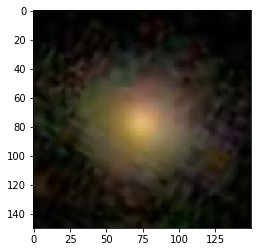

S0_9_7_34_588297863645626514.jpeg
Sabc : 56%   SBabc : 17%   S0 : 15%   SB0 : 9%   E0 : 0%   E3 : 0%   Edgeon : 0%   E7 : 0%   


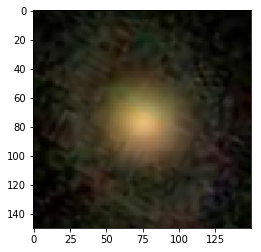

S0_12_6_35_588017627778056309.jpeg
S0 : 37%   SB0 : 29%   SBabc : 16%   Sabc : 15%   Edgeon : 0%   E3 : 0%   E0 : 0%   E7 : 0%   


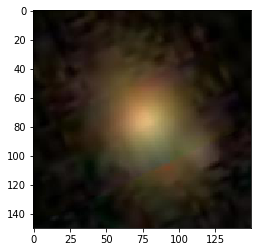

S0_12_7_35_587745403077263551.jpeg
SBabc : 39%   SB0 : 36%   S0 : 12%   Sabc : 9%   Edgeon : 2%   E3 : 0%   E7 : 0%   E0 : 0%   


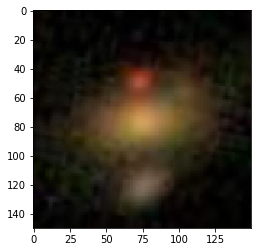

S0_5_5_64_587739811035677161.jpeg
S0 : 28%   SBabc : 28%   Sabc : 26%   SB0 : 15%   Edgeon : 1%   E3 : 0%   E0 : 0%   E7 : 0%   


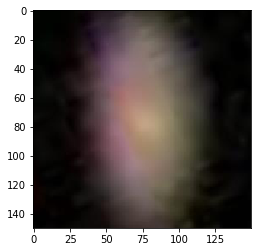

S0_1_11_107_587741531716714609.jpeg
Sabc : 80%   SBabc : 11%   S0 : 6%   SB0 : 1%   Edgeon : 0%   E0 : 0%   E3 : 0%   E7 : 0%   


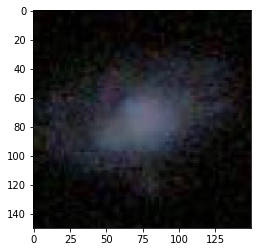

SB0_2_9_83_587728880881827991.jpeg
SBabc : 46%   SB0 : 25%   Sabc : 20%   S0 : 7%   Edgeon : 0%   E0 : 0%   E3 : 0%   E7 : 0%   


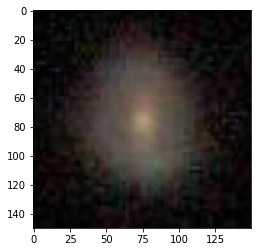

SB0_4_6_59_587741489838293171.jpeg
SB0 : 33%   SBabc : 25%   S0 : 19%   Edgeon : 11%   Sabc : 10%   E3 : 0%   E7 : 0%   E0 : 0%   


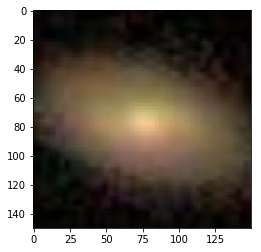

SB0_3_10_56_587726033318117543.jpeg
SB0 : 47%   SBabc : 28%   S0 : 12%   Sabc : 8%   Edgeon : 3%   E3 : 0%   E0 : 0%   E7 : 0%   


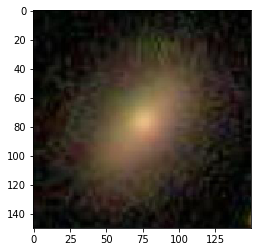

SB0_13_6_33_587735236882137203.jpeg
SB0 : 39%   SBabc : 24%   S0 : 24%   Sabc : 10%   Edgeon : 0%   E3 : 0%   E0 : 0%   E7 : 0%   


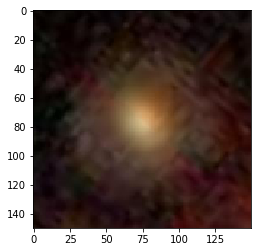

SB0_4_7_63_587741532251357277.jpeg
SB0 : 93%   SBabc : 6%   S0 : 0%   E3 : 0%   Sabc : 0%   E0 : 0%   E7 : 0%   Edgeon : 0%   


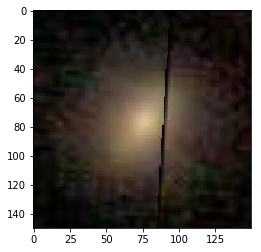

SB0_6_5_61_588017712586752008.jpeg
SBabc : 36%   Sabc : 34%   S0 : 15%   SB0 : 14%   Edgeon : 0%   E0 : 0%   E3 : 0%   E7 : 0%   


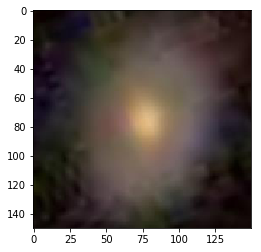

SB0_6_6_59_587741532777283701.jpeg
S0 : 39%   SB0 : 38%   SBabc : 10%   Sabc : 6%   Edgeon : 2%   E3 : 0%   E0 : 0%   E7 : 0%   


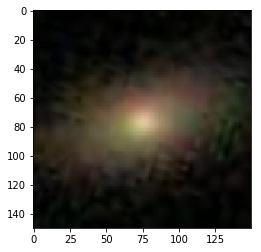

SB0_9_10_32_587739407291449650.jpeg
Edgeon : 31%   SB0 : 25%   SBabc : 17%   S0 : 15%   Sabc : 9%   E3 : 0%   E7 : 0%   E0 : 0%   


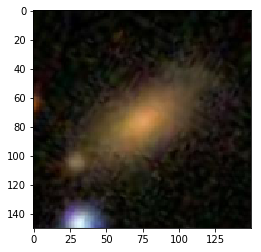

SB0_11_7_28_588010879295684802.jpeg
Sabc : 47%   SBabc : 41%   S0 : 6%   SB0 : 3%   Edgeon : 0%   E3 : 0%   E0 : 0%   E7 : 0%   


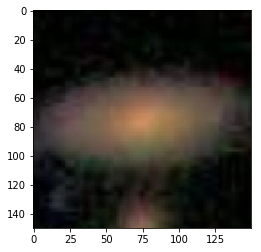

SB0_11_6_35_587729388213043321.jpeg
SB0 : 43%   SBabc : 26%   S0 : 19%   Sabc : 9%   Edgeon : 0%   E3 : 0%   E0 : 0%   E7 : 0%   


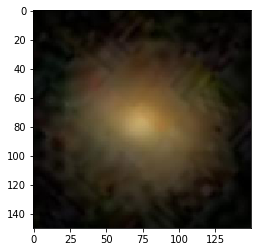

SBabc_11_5_40_587733442127790616.jpeg
SBabc : 58%   Sabc : 18%   SB0 : 10%   S0 : 10%   Edgeon : 1%   E3 : 0%   E0 : 0%   E7 : 0%   


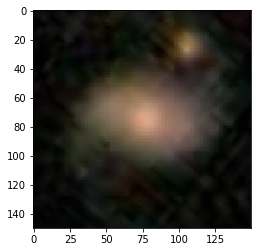

SBabc_7_6_40_587739376157065613.jpeg
SBabc : 44%   Sabc : 32%   SB0 : 13%   S0 : 9%   Edgeon : 0%   E0 : 0%   E3 : 0%   E7 : 0%   


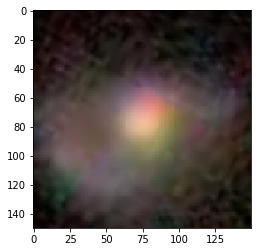

SBabc_4_7_67_587742013275635837.jpeg
SBabc : 51%   Sabc : 38%   S0 : 5%   SB0 : 3%   Edgeon : 0%   E0 : 0%   E3 : 0%   E7 : 0%   


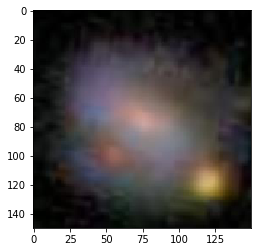

SBabc_6_6_56_587729160054571220.jpeg
SBabc : 52%   SB0 : 41%   Sabc : 3%   S0 : 2%   Edgeon : 0%   E3 : 0%   E7 : 0%   E0 : 0%   


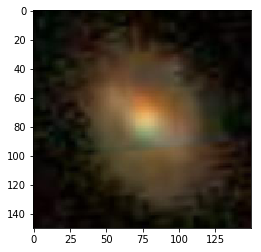

SBabc_4_10_81_587742578053087329.jpeg
SBabc : 69%   Sabc : 14%   SB0 : 14%   S0 : 1%   Edgeon : 0%   E3 : 0%   E0 : 0%   E7 : 0%   


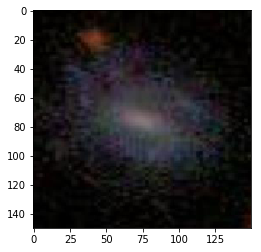

SBabc_5_8_41_587731870164058211.jpeg
SBabc : 57%   Sabc : 22%   SB0 : 11%   S0 : 7%   Edgeon : 0%   E3 : 0%   E7 : 0%   E0 : 0%   


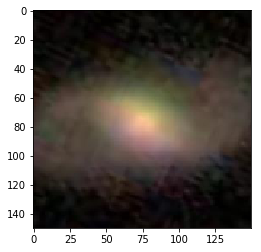

SBabc_5_6_67_587737827285532934.jpeg
SBabc : 85%   SB0 : 11%   Sabc : 3%   S0 : 0%   Edgeon : 0%   E3 : 0%   E7 : 0%   E0 : 0%   


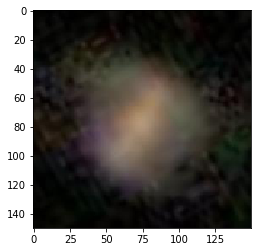

SBabc_9_5_42_587734840668520908.jpeg
SBabc : 76%   SB0 : 14%   Sabc : 6%   S0 : 2%   Edgeon : 0%   E3 : 0%   E0 : 0%   E7 : 0%   


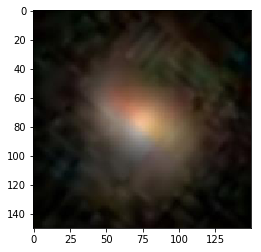

SBabc_10_5_42_587742061081002200.jpeg
SB0 : 62%   S0 : 20%   SBabc : 11%   Sabc : 3%   Edgeon : 1%   E3 : 0%   E0 : 0%   E7 : 0%   


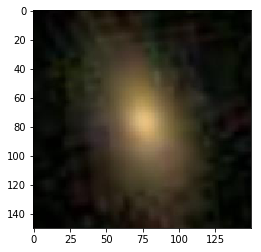

SBabc_1_11_82_587725491599900890.jpeg
Edgeon : 62%   SBabc : 15%   Sabc : 11%   S0 : 6%   SB0 : 3%   E7 : 0%   E3 : 0%   E0 : 0%   


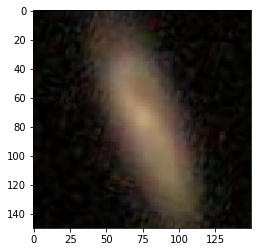

Sabc_6_9_37_587732577764638919.jpeg
SBabc : 41%   Sabc : 32%   S0 : 14%   SB0 : 8%   Edgeon : 2%   E0 : 0%   E3 : 0%   E7 : 0%   


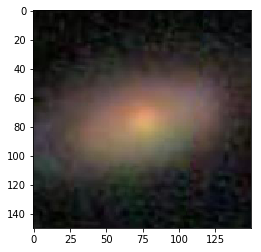

Sabc_10_5_42_588017702396166232.jpeg
Sabc : 47%   SBabc : 38%   S0 : 8%   SB0 : 4%   Edgeon : 0%   E0 : 0%   E3 : 0%   E7 : 0%   


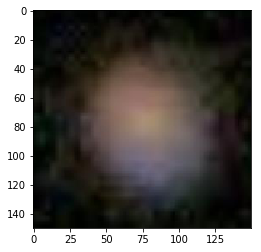

Sabc_10_4_43_587735349087764800.jpeg
SBabc : 41%   Sabc : 31%   SB0 : 14%   S0 : 11%   Edgeon : 0%   E0 : 0%   E3 : 0%   E7 : 0%   


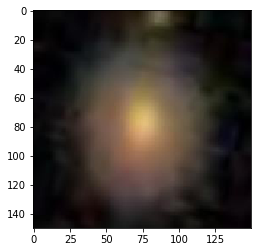

Sabc_3_9_57_588023668636188967.jpeg
Sabc : 55%   SBabc : 27%   S0 : 12%   SB0 : 4%   Edgeon : 0%   E0 : 0%   E3 : 0%   E7 : 0%   


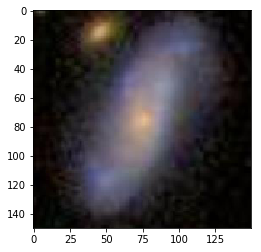

Sabc_9_7_45_587731873384825309.jpeg
Edgeon : 32%   SBabc : 28%   Sabc : 27%   S0 : 8%   SB0 : 3%   E3 : 0%   E7 : 0%   E0 : 0%   


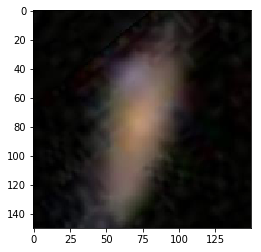

Sabc_10_12_34_588017605753569356.jpeg
Sabc : 41%   SBabc : 31%   S0 : 15%   SB0 : 10%   E0 : 0%   E3 : 0%   Edgeon : 0%   E7 : 0%   


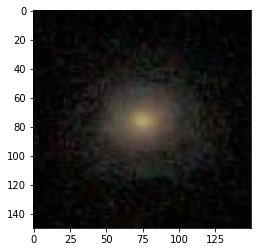

Sabc_5_8_54_588018089466790069.jpeg
SBabc : 78%   Sabc : 18%   SB0 : 2%   S0 : 0%   Edgeon : 0%   E3 : 0%   E0 : 0%   E7 : 0%   


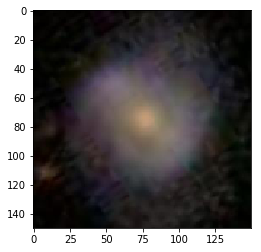

Sabc_12_6_35_587735662089797731.jpeg
S0 : 47%   SB0 : 26%   Sabc : 15%   SBabc : 11%   Edgeon : 0%   E0 : 0%   E3 : 0%   E7 : 0%   


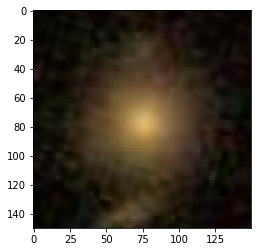

Sabc_1_13_89_587742864212820087.jpeg
Sabc : 36%   SBabc : 29%   S0 : 16%   SB0 : 10%   Edgeon : 6%   E3 : 0%   E0 : 0%   E7 : 0%   


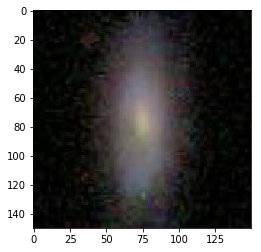

Sabc_5_6_52_587732152029479114.jpeg
Sabc : 73%   SBabc : 16%   S0 : 8%   SB0 : 1%   Edgeon : 0%   E0 : 0%   E3 : 0%   E7 : 0%   


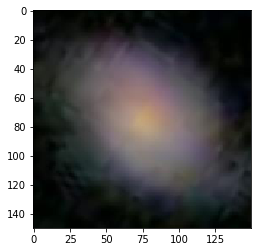

In [9]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from PIL import Image

#クラス予測サンプリング数
sample_size = 10

class_indices_dict = test_generator.class_indices
print(class_indices_dict)
#{'E0': 0, 'E3': 1, 'E7': 2, 'Edgeon': 3, 'SA0': 4, 'SAabc': 5, 'SB0': 6, 'SBabc': 7}
class_list = list(class_indices_dict.keys())

for class_name in class_list:
    prediction_fnames_series = pd.Series(np.array(os.listdir(test_generator_directory + '/' + class_name)))
    prediction_fnames_selected = prediction_fnames_series.sample(n=sample_size).values
    
    for prediction_fname in prediction_fnames_selected:
        print(prediction_fname)
        prediction_img = load_img(test_generator_directory + '/' + class_name + '/' + prediction_fname, target_size = (150,150))
        prediction_arr = img_to_array(prediction_img)
        prediction_arr /= 255.0
        input_arr = prediction_arr.reshape(1,150,150,3)
        probs = model.predict(input_arr)[0]
        probs_series_sorted = pd.Series(probs, index = class_list).sort_values(ascending=False)
        #print(probs_series_sorted.index)
        #print(probs_series_sorted)
        prediction_results = ''
        for class_index in probs_series_sorted.index:
            prediction_results += class_index + ' : ' + str(int(probs_series_sorted[class_index] * 100)) + '%' + '   ' 
            #prediction_results_list = prediction_results_list.append(prediction_results)                                             
            
        print(prediction_results)                                              
        plt.imshow(input_arr[0])
        plt.show()
        